In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/train"
val_dir = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test"
test_dir = "/kaggle/input/hamtraintest-224x224/content/HamTrainTest/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 8912
Number of images in validation dataset: 1103
Number of images in test dataset: 1103


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch.nn as nn
from torchvision.models import mobilenet_v2

class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2Classifier, self).__init__()
        # Load the pretrained MobileNetV2 model
        self.model = mobilenet_v2(pretrained=True)
        # Replace the final classifier layer to match the number of classes
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [8]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [9]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [10]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [11]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [13]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=8882fa25e3c5ee50e85499c63d17a550380e565b77da28bc29b9472604f9d764
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=8ee7763506e88a94287f9e856461d498a28fc916b6cdef71968e62d362c66743
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import time
import copy

# Define snapshot ensemble function
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):

    ensemble_models = []
    snapshot_epochs = [30, 70, 120]
    best_snapshot_weights = None

    model = MobileNetV2Classifier(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    # FLOPs and parameter count
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    flops = FlopCountAnalysis(model, sample_input)
    print("Model FLOPs and Parameter Count:")
    print(parameter_count_table(model))
    print(f"Total FLOPs: {flops.total() / 1e9:.2f} GFLOPs")

    criterion = CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)

    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)

        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/{total_epochs}, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)

        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")

        # Validation phase
        model.eval()
        torch.cuda.reset_peak_memory_stats(device)
        start_time = time.time()

        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        end_time = time.time()
        inference_time = end_time - start_time
        memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)

        print(f"Validation Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)

        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []

            start_time = time.time()
            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
            end_time = time.time()

            inference_time = end_time - start_time
            memory_used = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
            print(f"Test Inference Time: {inference_time:.2f} sec, Peak GPU Memory: {memory_used:.2f} MB")

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)

            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))

            conf_matrix = confusion_matrix(test_labels, test_preds)
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')

            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()


        scheduler.step()

    return ensemble_models


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


Using 2 GPUs!
Model FLOPs and Parameter Count:
| name                       | #elements or shape   |
|:---------------------------|:---------------------|
| model                      | 2.2M                 |
|  module                    |  2.2M                |
|   module.model             |   2.2M               |
|    module.model.features   |    2.2M              |
|    module.model.classifier |    9.0K              |
Total FLOPs: 0.33 GFLOPs
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


Train Loss: 0.4274, Accuracy: 0.6973, Precision: 0.6802, Recall: 0.6973, F1 Score: 0.6866


Validation: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Inference Time: 9.22 sec, Peak GPU Memory: 771.68 MB
Validation Loss: 0.2374, Accuracy: 0.8713, Precision: 0.8595, Recall: 0.8713, F1 Score: 0.8617
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120: 100%|██████████| 70/70 [00:38<00:00,  1.81it/s]


Train Loss: 0.2673, Accuracy: 0.8211, Precision: 0.8134, Recall: 0.8211, F1 Score: 0.8093


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


Validation Inference Time: 3.45 sec, Peak GPU Memory: 781.28 MB
Validation Loss: 0.2275, Accuracy: 0.8894, Precision: 0.8846, Recall: 0.8894, F1 Score: 0.8805
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


Train Loss: 0.2217, Accuracy: 0.8706, Precision: 0.8653, Recall: 0.8706, F1 Score: 0.8653


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Validation Inference Time: 3.52 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2161, Accuracy: 0.8994, Precision: 0.8917, Recall: 0.8994, F1 Score: 0.8938
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.1833, Accuracy: 0.9241, Precision: 0.9227, Recall: 0.9241, F1 Score: 0.9222


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


Validation Inference Time: 3.72 sec, Peak GPU Memory: 781.28 MB
Validation Loss: 0.2246, Accuracy: 0.9021, Precision: 0.9057, Recall: 0.9021, F1 Score: 0.9015
Best model updated based on validation accuracy
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.1581, Accuracy: 0.9611, Precision: 0.9608, Recall: 0.9611, F1 Score: 0.9605


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Validation Inference Time: 3.44 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2194, Accuracy: 0.8985, Precision: 0.8952, Recall: 0.8985, F1 Score: 0.8961
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.1425, Accuracy: 0.9824, Precision: 0.9823, Recall: 0.9824, F1 Score: 0.9822


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Validation Inference Time: 3.25 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2253, Accuracy: 0.8930, Precision: 0.8877, Recall: 0.8930, F1 Score: 0.8894
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.1324, Accuracy: 0.9938, Precision: 0.9938, Recall: 0.9938, F1 Score: 0.9938


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


Validation Inference Time: 3.29 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2249, Accuracy: 0.8994, Precision: 0.8961, Recall: 0.8994, F1 Score: 0.8968
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.1263, Accuracy: 0.9975, Precision: 0.9975, Recall: 0.9975, F1 Score: 0.9975


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2260, Accuracy: 0.9003, Precision: 0.8946, Recall: 0.9003, F1 Score: 0.8936
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.1236, Accuracy: 0.9992, Precision: 0.9992, Recall: 0.9992, F1 Score: 0.9992


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Validation Inference Time: 3.34 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2237, Accuracy: 0.8885, Precision: 0.8853, Recall: 0.8885, F1 Score: 0.8856
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.1206, Accuracy: 0.9993, Precision: 0.9993, Recall: 0.9993, F1 Score: 0.9993


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Validation Inference Time: 3.46 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2236, Accuracy: 0.8966, Precision: 0.8899, Recall: 0.8966, F1 Score: 0.8913
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.1182, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2191, Accuracy: 0.8994, Precision: 0.8911, Recall: 0.8994, F1 Score: 0.8929
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]


Train Loss: 0.1169, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Validation Inference Time: 3.28 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2154, Accuracy: 0.9003, Precision: 0.8948, Recall: 0.9003, F1 Score: 0.8960
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.1155, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2164, Accuracy: 0.8948, Precision: 0.8905, Recall: 0.8948, F1 Score: 0.8897
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.1137, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


Validation Inference Time: 3.20 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2155, Accuracy: 0.8921, Precision: 0.8889, Recall: 0.8921, F1 Score: 0.8880
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.1121, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2133, Accuracy: 0.8912, Precision: 0.8850, Recall: 0.8912, F1 Score: 0.8851
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120: 100%|██████████| 70/70 [00:39<00:00,  1.75it/s]


Train Loss: 0.1109, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2089, Accuracy: 0.8985, Precision: 0.8935, Recall: 0.8985, F1 Score: 0.8932
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.1096, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Validation Inference Time: 3.34 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2065, Accuracy: 0.8930, Precision: 0.8872, Recall: 0.8930, F1 Score: 0.8881
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.1083, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2061, Accuracy: 0.8948, Precision: 0.8884, Recall: 0.8948, F1 Score: 0.8895
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.1073, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.2045, Accuracy: 0.8985, Precision: 0.8918, Recall: 0.8985, F1 Score: 0.8926
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.1060, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Validation Inference Time: 3.58 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1987, Accuracy: 0.8948, Precision: 0.8904, Recall: 0.8948, F1 Score: 0.8907
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.1050, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1999, Accuracy: 0.8966, Precision: 0.8939, Recall: 0.8966, F1 Score: 0.8926
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.1039, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


Validation Inference Time: 3.14 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1970, Accuracy: 0.9021, Precision: 0.8978, Recall: 0.9021, F1 Score: 0.8967
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.1028, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Validation Inference Time: 3.36 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1967, Accuracy: 0.8966, Precision: 0.8935, Recall: 0.8966, F1 Score: 0.8919
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]


Train Loss: 0.1016, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1950, Accuracy: 0.8985, Precision: 0.8949, Recall: 0.8985, F1 Score: 0.8942
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120: 100%|██████████| 70/70 [00:39<00:00,  1.76it/s]


Train Loss: 0.1005, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


Validation Inference Time: 3.38 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1944, Accuracy: 0.8976, Precision: 0.8914, Recall: 0.8976, F1 Score: 0.8918
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0995, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Validation Inference Time: 3.34 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1912, Accuracy: 0.8994, Precision: 0.8950, Recall: 0.8994, F1 Score: 0.8950
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0986, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


Validation Inference Time: 3.21 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1917, Accuracy: 0.9003, Precision: 0.8930, Recall: 0.9003, F1 Score: 0.8943
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0977, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1902, Accuracy: 0.8985, Precision: 0.8924, Recall: 0.8985, F1 Score: 0.8931
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0966, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


Validation Inference Time: 3.23 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1896, Accuracy: 0.8957, Precision: 0.8901, Recall: 0.8957, F1 Score: 0.8899
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0957, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 779.64 MB
Validation Loss: 0.1858, Accuracy: 0.8985, Precision: 0.8943, Recall: 0.8985, F1 Score: 0.8938
Snapshot 0 saved


Testing: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Test Inference Time: 3.36 sec, Peak GPU Memory: 789.24 MB
Test Loss: 0.1832, Accuracy: 0.9021, Precision: 0.9057, Recall: 0.9021, F1 Score: 0.9015
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.74      0.47      0.57        30
           1       0.66      0.60      0.63        35
           2       0.77      0.65      0.70        88
           3       0.80      0.50      0.62         8
           4       0.44      0.63      0.52        46
           5       0.96      0.97      0.97       883
           6       1.00      0.85      0.92        13

    accuracy                           0.90      1103
   macro avg       0.77      0.67      0.70      1103
weighted avg       0.91      0.90      0.90      1103



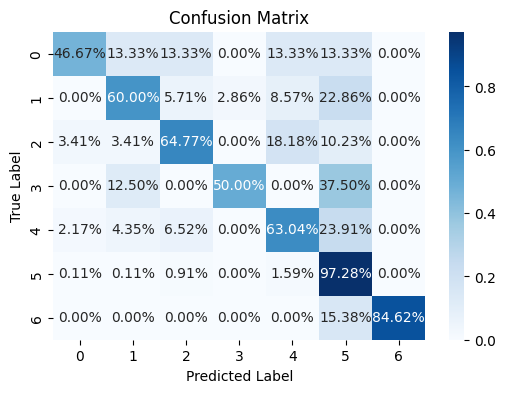

Test Sensitivity: 1.0000, Test Specificity: 0.7778


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


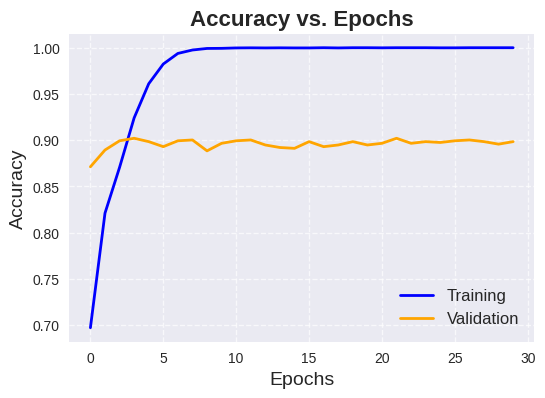

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


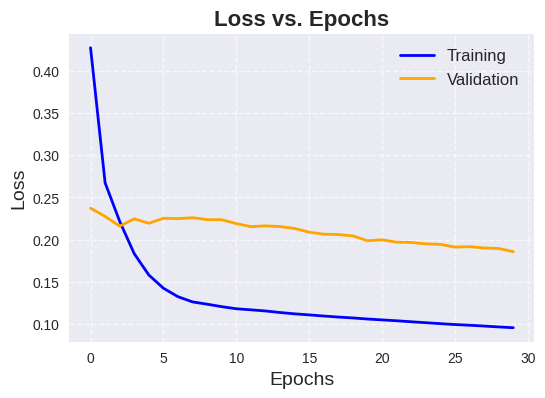

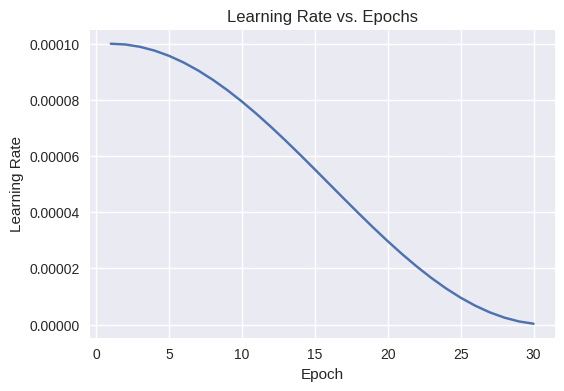

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.1357, Accuracy: 0.9470, Precision: 0.9463, Recall: 0.9470, F1 Score: 0.9463


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Validation Inference Time: 3.28 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1885, Accuracy: 0.8948, Precision: 0.8944, Recall: 0.8948, F1 Score: 0.8932
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]


Train Loss: 0.1144, Accuracy: 0.9801, Precision: 0.9801, Recall: 0.9801, F1 Score: 0.9800


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1897, Accuracy: 0.9030, Precision: 0.8965, Recall: 0.9030, F1 Score: 0.8973
Best model updated based on validation accuracy
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.1059, Accuracy: 0.9925, Precision: 0.9925, Recall: 0.9925, F1 Score: 0.9925


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.40 sec, Peak GPU Memory: 790.48 MB
Validation Loss: 0.1925, Accuracy: 0.8939, Precision: 0.8950, Recall: 0.8939, F1 Score: 0.8926
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Train Loss: 0.1006, Accuracy: 0.9973, Precision: 0.9973, Recall: 0.9973, F1 Score: 0.9973


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Validation Inference Time: 3.27 sec, Peak GPU Memory: 790.48 MB
Validation Loss: 0.1814, Accuracy: 0.8994, Precision: 0.8954, Recall: 0.8994, F1 Score: 0.8961
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0969, Accuracy: 0.9988, Precision: 0.9988, Recall: 0.9988, F1 Score: 0.9988


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 790.48 MB
Validation Loss: 0.1854, Accuracy: 0.8985, Precision: 0.8898, Recall: 0.8985, F1 Score: 0.8908
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0951, Accuracy: 0.9991, Precision: 0.9991, Recall: 0.9991, F1 Score: 0.9991


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Validation Inference Time: 3.50 sec, Peak GPU Memory: 790.48 MB
Validation Loss: 0.1776, Accuracy: 0.9039, Precision: 0.9021, Recall: 0.9039, F1 Score: 0.9011
Best model updated based on validation accuracy
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0926, Accuracy: 0.9997, Precision: 0.9997, Recall: 0.9997, F1 Score: 0.9997


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Validation Inference Time: 3.62 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1774, Accuracy: 0.9030, Precision: 0.8961, Recall: 0.9030, F1 Score: 0.8972
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0906, Accuracy: 0.9997, Precision: 0.9997, Recall: 0.9997, F1 Score: 0.9997


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Validation Inference Time: 3.27 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1768, Accuracy: 0.9030, Precision: 0.9030, Recall: 0.9030, F1 Score: 0.9010
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0889, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


Validation Inference Time: 3.33 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1751, Accuracy: 0.9048, Precision: 0.8949, Recall: 0.9048, F1 Score: 0.8968
Best model updated based on validation accuracy
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120: 100%|██████████| 70/70 [00:40<00:00,  1.75it/s]


Train Loss: 0.0879, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 790.48 MB
Validation Loss: 0.1671, Accuracy: 0.9139, Precision: 0.9077, Recall: 0.9139, F1 Score: 0.9083
Best model updated based on validation accuracy
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0864, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Validation Inference Time: 3.36 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1683, Accuracy: 0.8985, Precision: 0.9009, Recall: 0.8985, F1 Score: 0.8964
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0852, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


Validation Inference Time: 3.22 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1657, Accuracy: 0.9003, Precision: 0.8959, Recall: 0.9003, F1 Score: 0.8961
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0837, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


Validation Inference Time: 3.39 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1660, Accuracy: 0.9012, Precision: 0.8931, Recall: 0.9012, F1 Score: 0.8949
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0826, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Validation Inference Time: 3.34 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1619, Accuracy: 0.9057, Precision: 0.9028, Recall: 0.9057, F1 Score: 0.9012
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0815, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.90it/s]


Validation Inference Time: 3.12 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1627, Accuracy: 0.8985, Precision: 0.8936, Recall: 0.8985, F1 Score: 0.8932
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0805, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


Validation Inference Time: 3.31 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1596, Accuracy: 0.9030, Precision: 0.8983, Recall: 0.9030, F1 Score: 0.8980
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]


Train Loss: 0.0792, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Validation Inference Time: 3.28 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1587, Accuracy: 0.8994, Precision: 0.8919, Recall: 0.8994, F1 Score: 0.8934
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0780, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


Validation Inference Time: 3.14 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1569, Accuracy: 0.9012, Precision: 0.8943, Recall: 0.9012, F1 Score: 0.8961
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0769, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


Validation Inference Time: 3.26 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1558, Accuracy: 0.9048, Precision: 0.8961, Recall: 0.9048, F1 Score: 0.8985
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0760, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Validation Inference Time: 3.35 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1534, Accuracy: 0.9003, Precision: 0.8990, Recall: 0.9003, F1 Score: 0.8967
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]


Train Loss: 0.0747, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1528, Accuracy: 0.9039, Precision: 0.9001, Recall: 0.9039, F1 Score: 0.8993
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0736, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


Validation Inference Time: 3.15 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1501, Accuracy: 0.9012, Precision: 0.8977, Recall: 0.9012, F1 Score: 0.8976
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0727, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


Validation Inference Time: 3.13 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1492, Accuracy: 0.8985, Precision: 0.8964, Recall: 0.8985, F1 Score: 0.8949
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120: 100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


Train Loss: 0.0718, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


Validation Inference Time: 3.26 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1506, Accuracy: 0.8976, Precision: 0.8963, Recall: 0.8976, F1 Score: 0.8934
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0707, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Validation Inference Time: 3.50 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1469, Accuracy: 0.9012, Precision: 0.8963, Recall: 0.9012, F1 Score: 0.8969
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0695, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


Validation Inference Time: 3.26 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1439, Accuracy: 0.9021, Precision: 0.8971, Recall: 0.9021, F1 Score: 0.8975
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0685, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1445, Accuracy: 0.9012, Precision: 0.8964, Recall: 0.9012, F1 Score: 0.8954
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0675, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Validation Inference Time: 3.34 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1423, Accuracy: 0.9012, Precision: 0.8952, Recall: 0.9012, F1 Score: 0.8953
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120: 100%|██████████| 70/70 [00:39<00:00,  1.75it/s]


Train Loss: 0.0665, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.84it/s]


Validation Inference Time: 3.18 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1413, Accuracy: 0.9039, Precision: 0.8996, Recall: 0.9039, F1 Score: 0.8990
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0656, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]


Validation Inference Time: 3.08 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1404, Accuracy: 0.9030, Precision: 0.8977, Recall: 0.9030, F1 Score: 0.8973
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120: 100%|██████████| 70/70 [00:39<00:00,  1.75it/s]


Train Loss: 0.0645, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1394, Accuracy: 0.9021, Precision: 0.8959, Recall: 0.9021, F1 Score: 0.8962
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120: 100%|██████████| 70/70 [00:40<00:00,  1.75it/s]


Train Loss: 0.0637, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1369, Accuracy: 0.9003, Precision: 0.8969, Recall: 0.9003, F1 Score: 0.8956
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]


Train Loss: 0.0628, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1346, Accuracy: 0.9012, Precision: 0.8928, Recall: 0.9012, F1 Score: 0.8948
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120: 100%|██████████| 70/70 [00:41<00:00,  1.71it/s]


Train Loss: 0.0616, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.81it/s]


Validation Inference Time: 3.21 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1350, Accuracy: 0.9012, Precision: 0.8966, Recall: 0.9012, F1 Score: 0.8952
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120: 100%|██████████| 70/70 [00:40<00:00,  1.74it/s]


Train Loss: 0.0606, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1332, Accuracy: 0.9012, Precision: 0.9018, Recall: 0.9012, F1 Score: 0.8977
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0597, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1317, Accuracy: 0.8994, Precision: 0.8927, Recall: 0.8994, F1 Score: 0.8934
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0588, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1285, Accuracy: 0.9012, Precision: 0.8955, Recall: 0.9012, F1 Score: 0.8963
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0578, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]


Validation Inference Time: 3.65 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1287, Accuracy: 0.9030, Precision: 0.8995, Recall: 0.9030, F1 Score: 0.8978
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0567, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


Validation Inference Time: 3.32 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1273, Accuracy: 0.9003, Precision: 0.8952, Recall: 0.9003, F1 Score: 0.8949
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120: 100%|██████████| 70/70 [00:40<00:00,  1.73it/s]


Train Loss: 0.0558, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Validation Inference Time: 3.27 sec, Peak GPU Memory: 789.97 MB
Validation Loss: 0.1257, Accuracy: 0.9021, Precision: 0.8941, Recall: 0.9021, F1 Score: 0.8957
Snapshot 1 saved


Testing: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Test Inference Time: 3.34 sec, Peak GPU Memory: 799.44 MB
Test Loss: 0.1248, Accuracy: 0.9139, Precision: 0.9077, Recall: 0.9139, F1 Score: 0.9083
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        30
           1       0.85      0.63      0.72        35
           2       0.78      0.76      0.77        88
           3       0.75      0.38      0.50         8
           4       0.54      0.46      0.49        46
           5       0.95      0.98      0.97       883
           6       1.00      0.92      0.96        13

    accuracy                           0.91      1103
   macro avg       0.81      0.66      0.71      1103
weighted avg       0.91      0.91      0.91      1103



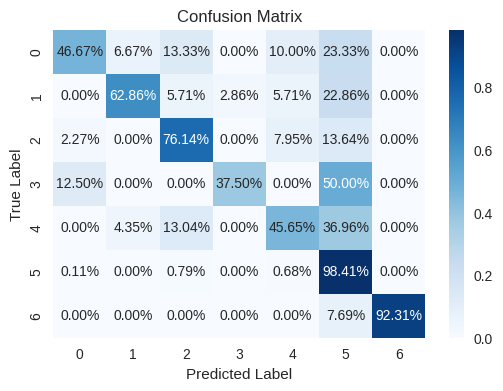

Test Sensitivity: 1.0000, Test Specificity: 0.8750


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


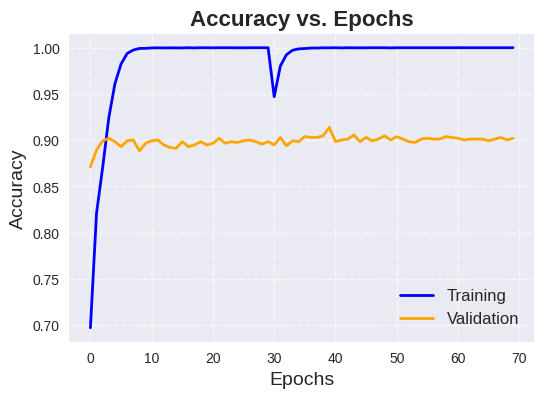

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


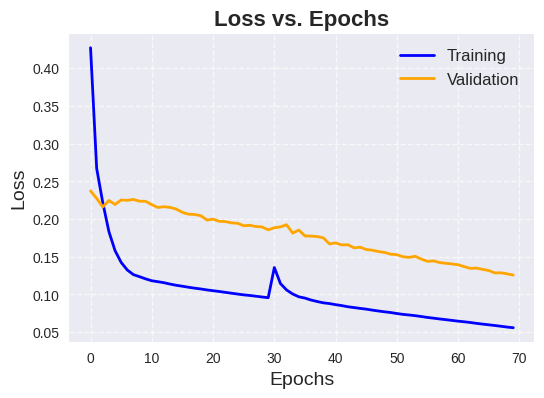

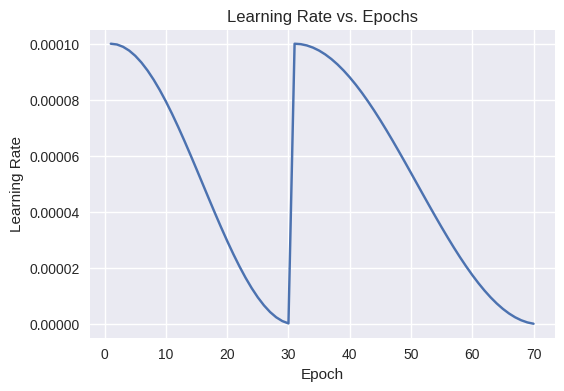

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0590, Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9989, F1 Score: 0.9989


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Validation Inference Time: 3.44 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1360, Accuracy: 0.8957, Precision: 0.9055, Recall: 0.8957, F1 Score: 0.8979
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0581, Accuracy: 0.9991, Precision: 0.9991, Recall: 0.9991, F1 Score: 0.9991


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


Validation Inference Time: 3.36 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1374, Accuracy: 0.8858, Precision: 0.8956, Recall: 0.8858, F1 Score: 0.8855
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0568, Accuracy: 0.9989, Precision: 0.9989, Recall: 0.9989, F1 Score: 0.9989


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Validation Inference Time: 3.60 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1304, Accuracy: 0.8994, Precision: 0.8890, Recall: 0.8994, F1 Score: 0.8911
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0554, Accuracy: 0.9992, Precision: 0.9992, Recall: 0.9992, F1 Score: 0.9992


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1296, Accuracy: 0.8957, Precision: 0.8846, Recall: 0.8957, F1 Score: 0.8860
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0535, Accuracy: 0.9992, Precision: 0.9992, Recall: 0.9992, F1 Score: 0.9992


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1257, Accuracy: 0.8939, Precision: 0.8947, Recall: 0.8939, F1 Score: 0.8918
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0518, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


Validation Inference Time: 3.44 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1245, Accuracy: 0.9012, Precision: 0.8997, Recall: 0.9012, F1 Score: 0.8977
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0507, Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9998, F1 Score: 0.9998


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


Validation Inference Time: 3.67 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1188, Accuracy: 0.9021, Precision: 0.8987, Recall: 0.9021, F1 Score: 0.8994
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0492, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Validation Inference Time: 3.62 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1186, Accuracy: 0.8921, Precision: 0.9008, Recall: 0.8921, F1 Score: 0.8938
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Train Loss: 0.0480, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1174, Accuracy: 0.8939, Precision: 0.8892, Recall: 0.8939, F1 Score: 0.8892
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120: 100%|██████████| 70/70 [00:42<00:00,  1.63it/s]


Train Loss: 0.0469, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Validation Inference Time: 3.45 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1179, Accuracy: 0.9003, Precision: 0.8990, Recall: 0.9003, F1 Score: 0.8964
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120: 100%|██████████| 70/70 [00:42<00:00,  1.67it/s]


Train Loss: 0.0456, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Validation Inference Time: 3.59 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1141, Accuracy: 0.9003, Precision: 0.8983, Recall: 0.9003, F1 Score: 0.8966
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0445, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


Validation Inference Time: 3.36 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1111, Accuracy: 0.9012, Precision: 0.8983, Recall: 0.9012, F1 Score: 0.8977
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0434, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


Validation Inference Time: 3.38 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1115, Accuracy: 0.8994, Precision: 0.8941, Recall: 0.8994, F1 Score: 0.8954
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120: 100%|██████████| 70/70 [00:41<00:00,  1.67it/s]


Train Loss: 0.0423, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Validation Inference Time: 3.62 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1100, Accuracy: 0.9030, Precision: 0.9011, Recall: 0.9030, F1 Score: 0.8989
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Train Loss: 0.0411, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]


Validation Inference Time: 3.52 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1087, Accuracy: 0.8985, Precision: 0.8973, Recall: 0.8985, F1 Score: 0.8940
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0402, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


Validation Inference Time: 3.56 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1063, Accuracy: 0.9021, Precision: 0.8997, Recall: 0.9021, F1 Score: 0.8989
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0390, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Validation Inference Time: 3.44 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1057, Accuracy: 0.8985, Precision: 0.8969, Recall: 0.8985, F1 Score: 0.8956
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Train Loss: 0.0381, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


Validation Inference Time: 3.32 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1049, Accuracy: 0.8985, Precision: 0.8966, Recall: 0.8985, F1 Score: 0.8959
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0370, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Validation Inference Time: 3.59 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1018, Accuracy: 0.9048, Precision: 0.9021, Recall: 0.9048, F1 Score: 0.9019
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0358, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


Validation Inference Time: 3.77 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1022, Accuracy: 0.9003, Precision: 0.8954, Recall: 0.9003, F1 Score: 0.8949
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120: 100%|██████████| 70/70 [00:45<00:00,  1.53it/s]


Train Loss: 0.0348, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


Validation Inference Time: 4.03 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.1013, Accuracy: 0.8994, Precision: 0.8975, Recall: 0.8994, F1 Score: 0.8952
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120: 100%|██████████| 70/70 [00:43<00:00,  1.63it/s]


Train Loss: 0.0337, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


Validation Inference Time: 3.34 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0985, Accuracy: 0.9012, Precision: 0.8975, Recall: 0.9012, F1 Score: 0.8979
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0327, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0975, Accuracy: 0.9039, Precision: 0.9018, Recall: 0.9039, F1 Score: 0.8996
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0316, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]


Validation Inference Time: 3.54 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0969, Accuracy: 0.9057, Precision: 0.9007, Recall: 0.9057, F1 Score: 0.9005
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0305, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Validation Inference Time: 3.47 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0956, Accuracy: 0.9021, Precision: 0.9001, Recall: 0.9021, F1 Score: 0.8974
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0294, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


Validation Inference Time: 3.30 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0950, Accuracy: 0.8985, Precision: 0.8948, Recall: 0.8985, F1 Score: 0.8932
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0284, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Validation Inference Time: 3.36 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0927, Accuracy: 0.9012, Precision: 0.9011, Recall: 0.9012, F1 Score: 0.8976
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120: 100%|██████████| 70/70 [00:42<00:00,  1.65it/s]


Train Loss: 0.0273, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]


Validation Inference Time: 3.49 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0920, Accuracy: 0.8957, Precision: 0.8940, Recall: 0.8957, F1 Score: 0.8918
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Train Loss: 0.0263, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]


Validation Inference Time: 3.78 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0912, Accuracy: 0.9003, Precision: 0.9014, Recall: 0.9003, F1 Score: 0.8984
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]


Train Loss: 0.0252, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


Validation Inference Time: 3.51 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0910, Accuracy: 0.8985, Precision: 0.8967, Recall: 0.8985, F1 Score: 0.8935
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0241, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Validation Inference Time: 3.50 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0899, Accuracy: 0.8948, Precision: 0.8917, Recall: 0.8948, F1 Score: 0.8897
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0230, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


Validation Inference Time: 3.58 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0879, Accuracy: 0.8957, Precision: 0.8936, Recall: 0.8957, F1 Score: 0.8920
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120: 100%|██████████| 70/70 [00:42<00:00,  1.65it/s]


Train Loss: 0.0219, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


Validation Inference Time: 4.12 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0880, Accuracy: 0.9021, Precision: 0.8978, Recall: 0.9021, F1 Score: 0.8972
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120: 100%|██████████| 70/70 [00:42<00:00,  1.67it/s]


Train Loss: 0.0209, Accuracy: 0.9999, Precision: 0.9999, Recall: 0.9999, F1 Score: 0.9999


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0854, Accuracy: 0.8957, Precision: 0.8967, Recall: 0.8957, F1 Score: 0.8934
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120: 100%|██████████| 70/70 [00:42<00:00,  1.64it/s]


Train Loss: 0.0198, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Validation Inference Time: 3.48 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0854, Accuracy: 0.8994, Precision: 0.8962, Recall: 0.8994, F1 Score: 0.8945
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0187, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


Validation Inference Time: 3.38 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0847, Accuracy: 0.8948, Precision: 0.8938, Recall: 0.8948, F1 Score: 0.8917
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120: 100%|██████████| 70/70 [00:40<00:00,  1.71it/s]


Train Loss: 0.0176, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.62it/s]


Validation Inference Time: 3.45 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0830, Accuracy: 0.9003, Precision: 0.8963, Recall: 0.9003, F1 Score: 0.8960
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0165, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0834, Accuracy: 0.9012, Precision: 0.8983, Recall: 0.9012, F1 Score: 0.8966
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120: 100%|██████████| 70/70 [00:42<00:00,  1.66it/s]


Train Loss: 0.0154, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Validation Inference Time: 3.47 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0817, Accuracy: 0.9003, Precision: 0.8988, Recall: 0.9003, F1 Score: 0.8971
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0142, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Validation Inference Time: 3.50 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0802, Accuracy: 0.8994, Precision: 0.8989, Recall: 0.8994, F1 Score: 0.8962
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120: 100%|██████████| 70/70 [00:40<00:00,  1.72it/s]


Train Loss: 0.0131, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0801, Accuracy: 0.8976, Precision: 0.8988, Recall: 0.8976, F1 Score: 0.8951
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0119, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


Validation Inference Time: 3.28 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0795, Accuracy: 0.9030, Precision: 0.8999, Recall: 0.9030, F1 Score: 0.8993
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0108, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Validation Inference Time: 3.36 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0786, Accuracy: 0.9012, Precision: 0.8981, Recall: 0.9012, F1 Score: 0.8966
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120: 100%|██████████| 70/70 [00:41<00:00,  1.68it/s]


Train Loss: 0.0096, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Validation Inference Time: 3.63 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0785, Accuracy: 0.8985, Precision: 0.8958, Recall: 0.8985, F1 Score: 0.8943
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0084, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.41 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0771, Accuracy: 0.9012, Precision: 0.8992, Recall: 0.9012, F1 Score: 0.8977
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0072, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


Validation Inference Time: 3.24 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0769, Accuracy: 0.8994, Precision: 0.8997, Recall: 0.8994, F1 Score: 0.8967
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120: 100%|██████████| 70/70 [00:41<00:00,  1.70it/s]


Train Loss: 0.0059, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.40 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0766, Accuracy: 0.9030, Precision: 0.9031, Recall: 0.9030, F1 Score: 0.8996
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120: 100%|██████████| 70/70 [00:41<00:00,  1.71it/s]


Train Loss: 0.0047, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]


Validation Inference Time: 3.47 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0752, Accuracy: 0.8976, Precision: 0.8986, Recall: 0.8976, F1 Score: 0.8950
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0035, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


Validation Inference Time: 3.40 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0740, Accuracy: 0.8966, Precision: 0.8928, Recall: 0.8966, F1 Score: 0.8914
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120: 100%|██████████| 70/70 [00:41<00:00,  1.69it/s]


Train Loss: 0.0023, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000


Validation: 100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


Validation Inference Time: 3.42 sec, Peak GPU Memory: 799.44 MB
Validation Loss: 0.0736, Accuracy: 0.9012, Precision: 0.9008, Recall: 0.9012, F1 Score: 0.8977
Snapshot 2 saved


Testing: 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]


Test Inference Time: 3.55 sec, Peak GPU Memory: 808.17 MB
Test Loss: 0.0718, Accuracy: 0.9139, Precision: 0.9077, Recall: 0.9139, F1 Score: 0.9083
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        30
           1       0.85      0.63      0.72        35
           2       0.78      0.76      0.77        88
           3       0.75      0.38      0.50         8
           4       0.54      0.46      0.49        46
           5       0.95      0.98      0.97       883
           6       1.00      0.92      0.96        13

    accuracy                           0.91      1103
   macro avg       0.81      0.66      0.71      1103
weighted avg       0.91      0.91      0.91      1103



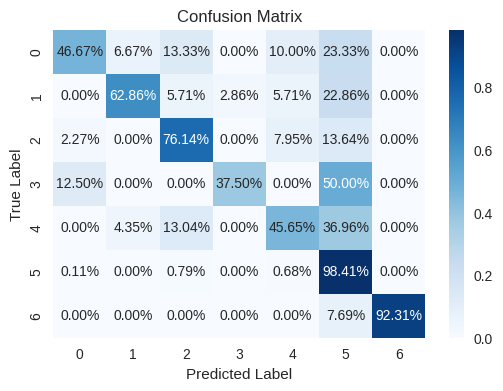

Test Sensitivity: 1.0000, Test Specificity: 0.8750


<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


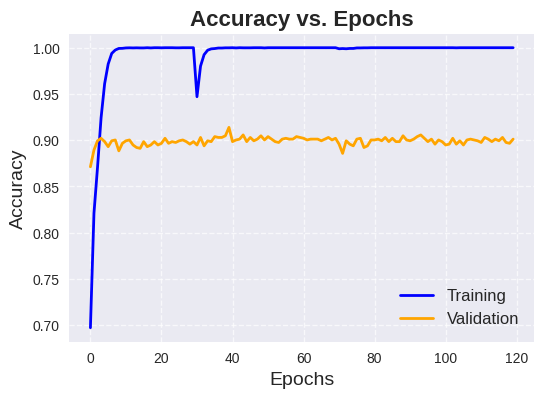

<ipython-input-10-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


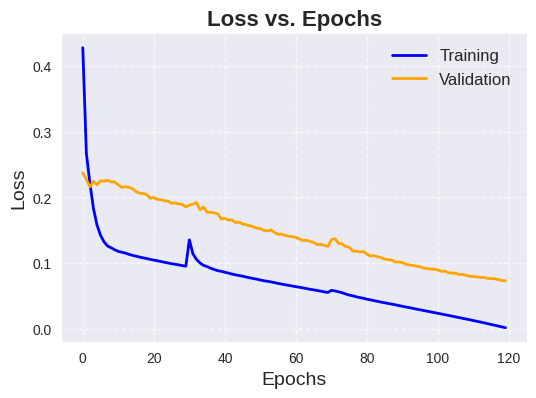

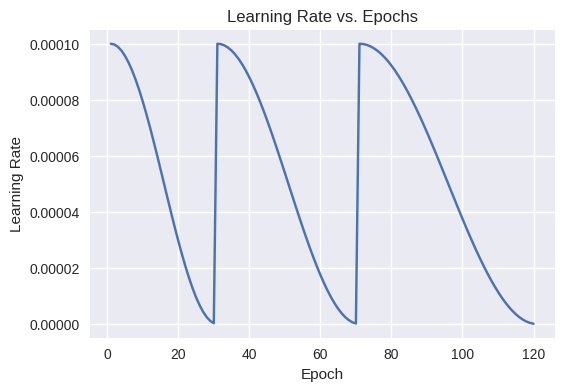

In [15]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)